In [3]:
import random
import math
import numpy as np
import re
from pyvi import ViTokenizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
# Đọc dữ liệu từ file
file_path = "data_NLP"   # Đường dẫn tới dữ liệu
line_limit = 200         # Giới hạn số dòng đọc từ file

with open(file_path, "r", encoding="utf-8") as file:
    lines = []
    for idx, line in enumerate(file):
        if idx >= line_limit:
            break
        lines.append(line.strip())  # Thêm dòng vào danh sách
    text = " ".join(lines)          # Kết hợp thành văn bản

# Làm sạch văn bản
def clean_text(text):
    text = text.lower()                      # Chuyển chữ thường
    text = re.sub(r"\d+", "", text)          # Loại bỏ chữ số
    text = re.sub(r"(\s)+", r"\1", text)     # Loại bỏ khoảng trắng thừa
    text = re.sub(r"<.*?>", "", text).strip()# Loại bỏ thẻ HTML
    text = re.sub(r"[^\w\s]", "", text)      # Loại bỏ dấu câu, ký tự đặc biệt
    return text

# Tách câu
def split_sentences(text):
    sentences = re.split(r"[.?!] +|\n+", text)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

# Tách từ bằng thư viện pyvi
def tokenize_sentence(sentence):return ViTokenizer.tokenize(sentence)

# Xây dựng từ điển
def build_vocab(corpus):
    vocab = {}
    for sentence in corpus:
        for word in sentence:
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab, {index: word for word, index in vocab.items()}

# 5. Đếm số từ trong tập văn bản
def count_tokens(corpus):
    return sum(len(sentence) for sentence in corpus)

# Tiền xử lý văn bản
cleaned_sentences = [clean_text(sentence) for sentence in split_sentences(text)]
tokenized_sentences = [tokenize_sentence(sentence).split() for sentence in cleaned_sentences]

# Tạo từ điển từ vựng
vocab, index_to_word = build_vocab(tokenized_sentences)

# Đếm tổng số từ (tokens)
total_tokens = count_tokens(tokenized_sentences)

# In kết quả
print("Các câu đã được tách từ:", tokenized_sentences)
print("Từ điển từ vựng:", vocab)
print(f"Tổng số từ trong văn bản: {total_tokens}")



Các câu đã được tách từ: [['giá', 'bất_động_sản', 'tiếp_tục', 'tăng', 'cho', 'đến', 'đầu', 'năm', 'khi', 'cuộc', 'khủng_hoảng', 'tài_chính', 'toàn_cầu', 'đã', 'làm', 'nổ', 'bong_bóng', 'bất_động_sản', 'của', 'tây_ban', 'nha']]
Từ điển từ vựng: {'giá': 0, 'bất_động_sản': 1, 'tiếp_tục': 2, 'tăng': 3, 'cho': 4, 'đến': 5, 'đầu': 6, 'năm': 7, 'khi': 8, 'cuộc': 9, 'khủng_hoảng': 10, 'tài_chính': 11, 'toàn_cầu': 12, 'đã': 13, 'làm': 14, 'nổ': 15, 'bong_bóng': 16, 'của': 17, 'tây_ban': 18, 'nha': 19}
Tổng số từ trong văn bản: 21


In [5]:
# Tạo dữ liệu huấn luyện (center, context) từ các câu
def generate_training_data(corpus, vocab, window_size):
    training_data = []
    for sentence in corpus:
        sentence_ids = [vocab.get(word) for word in sentence if word in vocab]  
        for center_idx, center_word_id in enumerate(sentence_ids):
            context_ids = [
                sentence_ids[i] 
                for i in range(max(0, center_idx - window_size), min(len(sentence_ids), center_idx + window_size + 1))
                if i != center_idx 
            ]
            training_data.extend([(center_word_id, context_word_id) for context_word_id in context_ids])
    
    return training_data

# Tạo dữ liệu huấn luyện Skip-gram
window_size=1
training_data = generate_training_data(tokenized_sentences, vocab, window_size)
print("Danh sách các cặp từ trung tâm và ngữ cảnh:", training_data)


Danh sách các cặp từ trung tâm và ngữ cảnh: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4), (5, 6), (6, 5), (6, 7), (7, 6), (7, 8), (8, 7), (8, 9), (9, 8), (9, 10), (10, 9), (10, 11), (11, 10), (11, 12), (12, 11), (12, 13), (13, 12), (13, 14), (14, 13), (14, 15), (15, 14), (15, 16), (16, 15), (16, 1), (1, 16), (1, 17), (17, 1), (17, 18), (18, 17), (18, 19), (19, 18)]


In [6]:

# Lớp EmbeddingLayer
class EmbeddingLayer:
    def __init__(self, vocab_size, embedding_dim):
        self.weights = np.random.uniform(-1, 1, (vocab_size, embedding_dim))

    def forward(self, x):
        return self.weights[x]

# Lớp SkipGram
class SkipGram:
    def __init__(self, vocab_size, embedding_dim, window_size):
        self.W1 = EmbeddingLayer(vocab_size, embedding_dim)
        self.W2 = np.random.uniform(-1, 1, (embedding_dim, vocab_size))
        self.window_size = window_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

    def forward(self, center_word_idx):
        return self.W1.forward(center_word_idx)

    def predict(self, center_word_idx):
        center_embedding = self.forward(center_word_idx)
        dot_products = np.dot(center_embedding, self.W2)
        return self.softmax(dot_products)

    def loss(self, center_word_idx, context_word_idx):
        predicted = self.predict(center_word_idx)
        loss = -np.log(predicted[context_word_idx])
        return loss

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum()

    def backpropagate(self, center_word_idx, context_word_idx, learning_rate):
        center_embedding = self.forward(center_word_idx)
        prediction = self.predict(center_word_idx)

        dL_dy = prediction.copy()
        dL_dy[context_word_idx] -= 1

        grad_W2 = np.outer(center_embedding, dL_dy)
        self.W2 -= learning_rate * grad_W2

        grad_W1 = np.dot(self.W2, dL_dy)
        self.W1.weights[center_word_idx] -= learning_rate * grad_W1


In [7]:
def train_skipgram_model(model, training_data, epochs, learning_rate):
    losses = []
    for epoch in range(epochs):
        loss = 0
        for center_word_idx, context_word_idx in training_data:
            if center_word_idx >= model.vocab_size or context_word_idx >= model.vocab_size:
                continue
            loss += model.loss(center_word_idx, context_word_idx)
            model.backpropagate(center_word_idx, context_word_idx, learning_rate)
        total_loss = loss / len(training_data)
        losses.append(total_loss)
        if (epoch == 0) or ((epoch + 1) % 5 == 0):
            print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

    plot_loss(losses)

def plot_loss(losses, color='green'):
    plt.plot(range(1, len(losses) + 1), losses, color=color)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.show()


Epoch 1, Loss: 6.6523
Epoch 5, Loss: 4.6710
Epoch 10, Loss: 3.0979
Epoch 15, Loss: 2.1503
Epoch 20, Loss: 1.5966
Epoch 25, Loss: 1.2731
Epoch 30, Loss: 1.0992
Epoch 35, Loss: 1.0083
Epoch 40, Loss: 0.9553
Epoch 45, Loss: 0.9249
Epoch 50, Loss: 0.9065
Epoch 55, Loss: 0.8939
Epoch 60, Loss: 0.8847
Epoch 65, Loss: 0.8775
Epoch 70, Loss: 0.8718
Epoch 75, Loss: 0.8671
Epoch 80, Loss: 0.8632
Epoch 85, Loss: 0.8599
Epoch 90, Loss: 0.8571
Epoch 95, Loss: 0.8547
Epoch 100, Loss: 0.8526


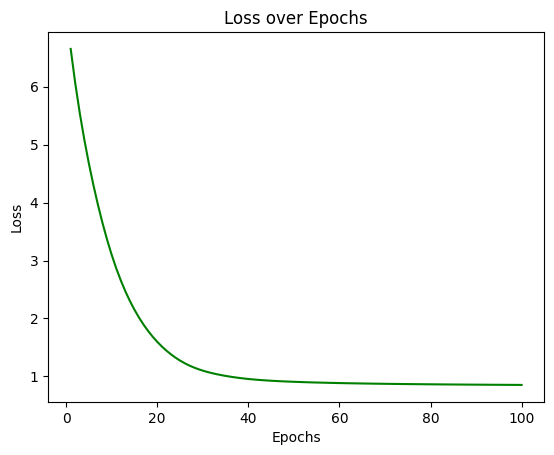

In [ ]:
# Khởi tạo mô hình Skip-gram và huấn luyện
embedding_dim = 100
vocab_size = len(vocab)
model = SkipGram(vocab_size, embedding_dim, window_size)
epochs = 1
learning_rate = 0.005
# Huấn luyện mô hình Skip-gram
train_skipgram_model(model, training_data, epochs, learning_rate)


In [9]:
#Tính cosine similarity giữa hai vector
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Phân chia các cặp từ thành hai nhóm
synonym_pairs = [
    ('phát_triển', 'cải_cách'),
    ('bình_quân', 'trung_bình'),
]

antonym_pairs = [
    ('nhanh', 'lâu'),
    ('tích_cực', 'tiêu_cực'),
]

#Tính toán cosine similarity cho mỗi cặp từ
def calculate_similarity(pairs, vocab, model):
    for word1, word2 in pairs:
        if word1 in vocab and word2 in vocab:
            # Lấy index của từ trong từ điển
            word1_idx = vocab[word1]
            word2_idx = vocab[word2]
            
            # Lấy embedding vector của các từ từ mô hình
            word1_embedding = model.W1.weights[word1_idx]  # Truy cập vector embedding từ W1
            word2_embedding = model.W1.weights[word2_idx]  # Truy cập vector embedding từ W1
            
            # Tính cosine similarity
            similarity = cosine_similarity(word1_embedding, word2_embedding)
            
            # In kết quả
            print(f"Từ 1: {word1}, Từ 2: {word2} -> Cosine Similarity: {similarity:.4f}")
        else:
            print(f"Không tìm thấy từ {word1} hoặc {word2} trong từ điển.")

# Tính cosine similarity cho từ đồng nghĩa và từ trái nghĩa
print("Tính toán cho các cặp từ tương đồng:")
calculate_similarity(synonym_pairs, vocab, model)

print("\nTính toán cho các cặp từ đối lặp:")
calculate_similarity(antonym_pairs, vocab, model)

# Trực quan hóa các từ
def visualize_embeddings(model, vocab, synonym_pairs, antonym_pairs):
    embeddings = []
    labels = []
    colors = []

    # Lấy vector embedding của các từ trong bộ kiểm tra từ đồng nghĩa
    for word1, word2 in synonym_pairs:
        if word1 in vocab and word2 in vocab:
            word1_idx = vocab[word1]
            word2_idx = vocab[word2]
            embeddings.extend([model.W1.weights[word1_idx], model.W1.weights[word2_idx]])
            labels.extend([word1, word2])
            colors.extend(['green', 'green'])

    # Lấy vector embedding của các từ trong bộ kiểm tra từ trái nghĩa
    for word1, word2 in antonym_pairs:
        if word1 in vocab and word2 in vocab:
            word1_idx = vocab[word1]
            word2_idx = vocab[word2]
            embeddings.extend([model.W1.weights[word1_idx], model.W1.weights[word2_idx]])
            labels.extend([word1, word2])
            colors.extend(['red', 'red'])

    # Chuyển các vector embedding thành một mảng numpy
    embeddings = np.array(embeddings)

    # Giảm chiều xuống 2D bằng t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, marker='o')

    for i, label in enumerate(labels):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label, fontsize=12)
    
    plt.title('Visualizing Word Embeddings')
    plt.grid(True) 
    plt.show()

# 5. Trực quan hóa các vector embedding
visualize_embeddings(model, vocab, synonym_pairs, antonym_pairs)

Tính toán cho các cặp từ tương đồng:
Không tìm thấy từ phát_triển hoặc cải_cách trong từ điển.
Không tìm thấy từ bình_quân hoặc trung_bình trong từ điển.

Tính toán cho các cặp từ đối lặp:
Không tìm thấy từ nhanh hoặc lâu trong từ điển.
Không tìm thấy từ tích_cực hoặc tiêu_cực trong từ điển.


ValueError: perplexity must be less than n_samples